In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.special import lpmv
from scipy.interpolate import griddata
from scipy.io import loadmat
from mpl_toolkits import mplot3d

plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams.update({'font.size': 9})

# Plots Ylm real-valued spherical harmonic functions.
# Carl Tape, Amanda McPherson
#
# The examples can be changed with the variable iex

In [2]:
# Set up examples and user flags

# additional options for more plots
imore1 = 0    # boolean: qth order grid properties
imore2 = 0    # boolean: sqrt(l(l+1)) plots

thtick = np.arange(-90,91,30,dtype=int)
phtick = np.arange(-90,91,30,dtype=int)
numc = 10                       # number of contour lines

# plotting with spherical grids in 3D
gdir = './data/'
gbox = [-1, 1, -1, 1, -1, 1]    # range for 3D axes
fc = [1, 1, 1]
az = 135   # 3D viewing angle
el = 20    # 3D viewing angle

# KEY COMMAND
# change this to see different examples (=0 to change parameters yourself)
# Future work: implement 3D plotting - currently icontour must NOT be 0.
iex = 1

# Set defaults
iq = -1
L = -1
M = -1
multifig = -1
fourbox = -1
fixedL = -1
icontour = -1

In [3]:
# Set up examples and user flags
if iex == 0:  # Manually change parameters here
    iq = -1
    L = -1
    M = -1
    multifig = -1
    fourbox = -1
    fixedL = -1
    icontour = -1
    
    if L < 0 or M < 0:
        raise Exception('Double check all your parameters are within bounds')
        
    elif M > L:
        raise Exception('M must be <= L')
        
    elif L == 0 and M == 0:
        raise Exception('L=0, M=0 is the breathing mode, which is spherically symmetric')
    
elif iex == 1:
    multifig = 1
    fixedL = 1
    icontour = 1
    L = 5
    
elif iex == 2:
    multifig = 0
    L = 5
    M = 2
    fourbox = 1
    iq = 3
    
elif iex == 3:
    multifig = 0
    L = 5
    M = 5
    fourbox = 1
    iq = 3
    
elif iex == 4:
    multifig = 0
    L = 5
    M = 0
    fourbox = 1
    iq = 3
    
elif iex == 5:
    multifig = 0
    L = 2
    M = 0
    fourbox = 1
    iq = 3
    
elif iex == 6:
    multifig = 1
    fixedL = 0
    icontour = 1
    M = 0
    L = 6 # Lmax for varying L
    
elif iex == 7:
    multifig = 1
    fixedL = 0
    #icontour = 0 # For the future
    icontour = 1
    M = 0
    L = 6 # Lmax for varying L
    
if multifig == 1:
    print('Plots for multiple Ylm (multifig = 1)')
    
    if icontour == 0:
        iq = 3
        
    else:
        iq = 4
    
elif multifig == 0:
    print('Plot for one Ylm (multifig = 0)')
    
else:
    raise Exception('multifig is Boolean - must be 0 or 1')

# If all you want is contour plots, then you do not need spherical grids
if icontour == 1:
    numt = 100
    xmin = -np.pi
    xmax = np.pi
    numx = numt
    ymin = 0
    ymax = np.pi
    
    xvec0 = np.linspace(xmin,xmax,numx)
    dx = xvec0[1] - xvec0[0]
    yvec0 = np.arange(ymin, ymax+dx, dx)
    

    X, Y = np.meshgrid(xvec0,yvec0)
    a,b = X.shape
    ph = np.reshape(X,(a*b,1))
    th = np.reshape(Y,(a*b,1))
    
    num = len(th)
    
else:
    # iq = 3 data for plotting the sphere
    data = loadmat('./data/Dgriddata3b')
    tvert0 = data['tvert']
    tface0 = data['tface']
    
    stiq = str(int(iq))
    stq = 'q=' + stiq
    
    if iq != 3:
        # LOAD THE TRIANGULAR GRID DATA FOR PLOTTING FIGURES
        dfile = gdir + 'Dgriddata' + stiq + 'b'
        data = loadmat(dfile)
        
    ph = data['phi']
    th = data['th']
    num = len(th)
    
npts = 100  # interpolation detail
ramp = 5
nr0 = 3
nc0 = 2

Plots for multiple Ylm (multifig = 1)


In [4]:
def xlm(th, LL):
    """ XLM generalized Legendre functions (xlm), Dahlen and Tromp p. 848
        Optional plots of L+1 xlm (0 <= M <= L), which requires you
        to use ifigs = 1 and execute as a script.

        Note: to look at legendre functions, use legplots3.m
 
        th = vector of polar angles (0 to pi)
        LL = degree for the spherical harmonic

        see Tape (2003) appendix in thesis for ylm notation and conventions
        
        xlm.m by Carl Tape, 2006-01-22
        
        Python adaptation by Amanda McPherson, 2021"""
    
    num = len(th)
    X   = np.cos(th)
    
    m = np.arange(LL+1)
    # THIS IS THE PYTHON CALCULATION OF THE ASSOCIATED LEGENDRE FUNCTIONS.
    # It calculates the functions from M = 0 to M = L.
    # We have to modify it to be consistent with the useage in JHW's programs:
    #       1. Multiply everything by factor A.
    #       2. Change the sign of every other order.
    #       3. Divide all non-M=0 values by sqrt(2)

    A = np.sqrt( (2*LL + 1) / (4*np.pi) )       # normalization (amplitude correction)
    legmat = lpmv(m, LL, X)
    legmat = A*legmat
    
    for MM in range(LL+1):
        # Changes the sign of every other column of values
        legmat[:,MM] = (-1)**MM * legmat[:,MM]
        
        # divides by sqrt(2) if M is not 0
        # Applies Schmidt normalization
        if MM != 0:
            norm = ((-1) ** MM) * np.sqrt((2 * np.math.factorial(LL - MM)) / np.math.factorial(LL + MM))
            legmat[:,MM] = norm * legmat[:,MM] / np.sqrt(2)
           
    return legmat

In [5]:
def ylm(th, phi, L, M):
    """ YLM surface spherical harmonic functions Y_lm

        Convention similar to Dahlen and Tromp (1999), p. 851.
        th    = vector of polar angles [0:pi]
        phi   = vector of azimuthal angles [-pi:pi]
        L     = degree
        M     = order [-L <= M <= L]
        
        calls xlm

        ylm.m by Carl Tape, 2003-02-24
        Python adaptation by Amanda McPherson, 2021 """
    
    num = len(th)
    
    if M == 0 and L == 0:
        raise Exception('L=0, M=0 is the breathing mode, which is spherically symmetric')
    
    pts = xlm(th, L)   # KEY COMMAND
    pts2 = pts[:,M]  # Python has M in the columns already
    
    # automatically does all the orders (0 <= M <= L)
    # returns a flattened ndarray of length num
    
    if M == 0:
        val = pts2
    
    elif M > 0 and M <= L:
        val = pts2 * np.sin(M*phi).flatten()
        
    else:
        raise Exception('invalid M or L: requirement that 0 <= M <= L')
        
    return val

In [6]:
def griddataX(phi, lat, alphcent, npts):
    """ This function takes lat-lon points (radians) and a function
        defined at each point, and it returns a set of points
        XYZ that can be plotted as a planar surface plot.
        Note that the lat-range is 180 and the lon-range is 360.

        phi       = longitude (radians)
        lat       = latitude (radians)
        alphcent  = function values defined at every gridpoint
        npts      = number of points to use in horizontal interpolation
        
        griddataX.m by Carl Tape
        Python adaptation by Amanda McPherson """
    
    deg = 180/np.pi
    
    # INTERPOLATION COMMANDS FOR SURFACE/CONTOUR PLOTS
    x = phi*deg
    y = lat*deg
    XY = np.append(x,y,axis=1)
    #z = alphcent.flatten()
    z = alphcent
    
    xlin = np.linspace(min(x), max(x), npts)
    xlin = np.reshape(xlin, (len(xlin),1))
    ylin = np.linspace(min(y), max(y), npts)
    ylin = np.reshape(ylin,(len(ylin),1))
    
    X, Y = np.meshgrid(xlin, ylin)
    Z = griddata(XY,z,(X,Y),method='cubic',fill_value=0)
    
    return X, Y, Z

In [7]:
def ylmplots_fun():
    """ Plots Ylm real spherical harmonic functions, either as a 3D figure or a 2D contour.
        ylmplots.m by Carl Tape, 2004-04-13
        Python adaptation by Amanda McPherson
        calls griddataX
        called by ylmplots """
    
    stit = 'L=%i, M=%i : (%i, %i)'% (L,M,2*M,L-M+1)
    lat = np.pi/2 - th
    
    if icontour == 0:
        # plot ylm as a 3D figure - IN THE FUTURE
        raise Exception('icontour=0 not implemented yet')
        rho = np.ones((num,1))   # unit sphere vectors
        r = ramp*rho + amp*alphcent
        xx = r * np.cos(lat) * np.cos(ph)
        xx = np.reshape(xx,(len(xx),1))
        yy = r * np.cos(lat) * np.sin(ph)
        yy = np.reshape(yy,(len(yy),1))
        zz = r * np.sin(lat)
        zz = np.reshape(zz,(len(zz),1))
        
        ylmvert = np.append(np.append(xx,yy,axis=1),zz,axis=1)
        # MORE WORK NEEDED
        
    else:
        X, Y, Z = griddataX(ph, lat, alphcent, npts)
        zmax = np.amax(abs(Z))
        
        plt.contour(X, Y, Z, levels=numc, vmin=-zmax, vmax=zmax)
        plt.xticks([-180, 0, 180])
        plt.yticks(thtick)
        plt.title(stit)
        plt.xlabel('Longitude (φ)')
        plt.ylabel('Latitude (90 - θ)')
        plt.axis([-180, 180, -90, 90])
        plt.colorbar()

now for some plots of different Ylm functions
Ylm plots: L fixed, M varies (L <= 14)


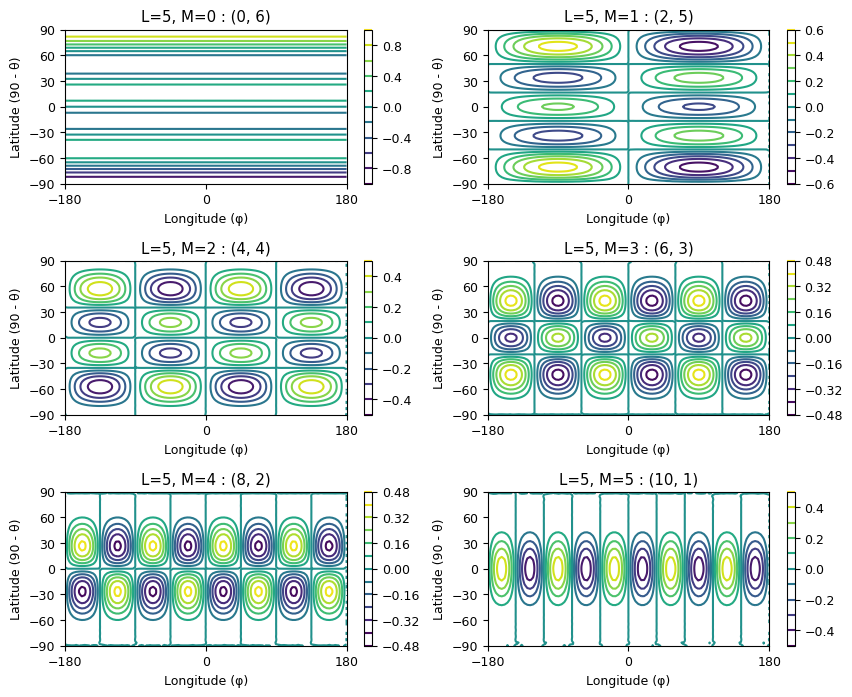

In [8]:
# PLOT THE YLM-FUNCTIONS of degree L, orders M = 0 to M = L
if multifig == 1:
    print('now for some plots of different Ylm functions')
    
    if fixedL == 1:
        print('Ylm plots: L fixed, M varies (L <= 14)')
        
        if L >= 2:
            amp = 2    # amplitude
            
            for M in range(L+1):
                if L == 2:
                    plt.subplot(nr0, nc0, M+4)
                elif L <= 5:
                    plt.subplot(3,2,M+1)
                elif L <= 7:
                    plt.subplot(4,2,M+1)
                elif L <= 9:
                    plt.subplot(5,2,M+1)
                elif L <= 14:
                    plt.subplot(5,3,M+1)
                #plt.figure()    
                alphcent = ylm(th,ph,L,M)
                ylmplots_fun()
                plt.subplots_adjust(hspace=0.5)
                
        elif L <= 2:
            amp = 6 # amplitude
            
            for M in range(2):
                L = 1
                
                plt.subplot(nr0,nc0,M+2)
                alphcent = ylm(th,ph,L,M)
                ylmplots_fun()
                plt.subplots_adjust(hspace=0.5)
                
            # 3D Plotting not implemented yet
            
    elif fixedL == 0:
        print('Ylm plots: M fixed, L varies')
        
        if L >= M:
            nr=4
            nc=2
            numL = nr*nc
            #numL = M - L
            #iLs = np.round(np.linspace(M,L,numL))
            iLs = np.arange(M,L+1)
            amp = 1    # amplitude
            
            plt.figure()
            for ii in range(numL):
                if ii >= len(iLs):
                    continue
                    
                L = int(iLs[ii])
                if L == 0:
                    continue
                    
                alphcent = ylm(th,ph,L,M)
                plt.subplot(nr,nc,ii+1)
                ylmplots_fun()
                
            plt.subplots_adjust(hspace=0.7)
                
        else:
            raise Exception('Conditions not met: L >= M')

# PLOT THE YLM-FUNCTION of degree L, order M
elif multifig == 0:
    print('now for some plots of one Ylm function')
    
    stit = 'L=%i, M=%i'% (L,M)
    stit2 = ': L-M+1=%i bulges with θ, 2M=%i bulges with φ (%i, %i)'% (L-M+1,2*M,2*M,L-M+1)
    
    alphcent = ylm(th,ph,L,M)
    # function values at each gridpoint; the input values are
    # the spherical coordinates of the tvert points (th, ph)
    
    # COMMANDS FOR PLOTTING ON THE TRIANGULAR GRIDS
    amp = 2 # default amplitude
    if L > 12:
        amp = 1
        
    stra = str(amp)
    rho = np.ones((num, 1))             # unit sphere vectors
    lat = np.pi/2 - th
    
    r = ramp*rho.flatten() + amp*alphcent.flatten()
    xix = r.flatten() * np.cos(lat).flatten() * np.cos(ph).flatten()
    xix = np.reshape(xix,(len(xix),1))
    yiy = r.flatten() * np.cos(lat).flatten() * np.sin(ph).flatten()
    yiy = np.reshape(yiy,(len(yiy),1))
    ziz = r.flatten() * np.sin(lat).flatten()
    ziz = np.reshape(ziz,(len(ziz),1))
    
    ylmvert = np.append(np.append(xix,yiy,axis=1),ziz,axis=1)
    
    # INTERPOLATION COMMANDS FOR SURFACE/CONTOUR PLOTS
    X, Y, Z = griddataX(ph, lat, alphcent, npts)

    zmax = np.amax(abs(Z))
    
    if fourbox == 1:
        # PLOT 1: 3D PLOT OF THE YLM FUNCTION
        # FUTURE WORK - 3D plotting
        #fig = plt.figure()
        #ax1 = plt.axes(projection='3d')
        #plt.subplot(3,2,1)
        
        # PLOT 2: LAT-LON SURFACE PLOT OF THE YLM FUNCTION
        # FUTURE WORK - 3D plotting
        #plt.subplot(3,2,2)
        fig2 = plt.figure()
        ax2 = plt.axes(projection='3d')
        ax2.plot_surface(X,Y,Z,vmin=-zmax,vmax=zmax,cmap='viridis')
        #ax2.axis([-180, 180, -90, 90, -1.3*zmax, 1.3*zmax])
        ax2.set_zlim([-1.3*zmax, 1.3*zmax])
        ax2.set(xlabel='Longitude (φ)',ylabel='Latitude (90 - θ)',zlabel='ylm value',title=stit)
        ax2.set_xticks([-180, 0, 180])
        ax2.set_yticks(thtick)
        
        # PLOT 3: LAT-LON CONTOUR PLOT OF THE YLM FUNCTION
        fig3 = plt.figure()
        plt.subplot(3,1,2)
        plt.contour(X, Y, Z, levels=numc, vmin=-zmax, vmax=zmax)
        plt.xticks([-180, 0, 180])
        plt.yticks(thtick)
        plt.xlabel('Longitude (φ)')
        plt.ylabel('Latitude (90 - θ)')
        plt.title(stit+stit2)
        plt.axis([-180, 180, -90, 90])
        plt.colorbar()
        
        # PLOT 4: LAT-LON SHADING-CONTOUR PLOT OF THE YLM FUNCTION
        plt.subplot(3,1,3)
        plt.pcolormesh(X,Y,Z,shading='gouraud', vmin=-zmax, vmax=zmax)
        plt.xticks([-180, 0, 180])
        plt.yticks(thtick)
        plt.xlabel('Longitude (φ)')
        plt.ylabel('Latitude (90 - θ)')
        plt.title(stit+stit2)
        plt.axis([-180, 180, -90, 90])
        plt.colorbar()
        
        plt.subplots_adjust(hspace=0.5)
        plt.show()
        
    else:
        # FUTURE WORK - 3D PLOTTING
        plt.subplots_adjust(hspace=0.5)
        plt.show()
        

In [9]:
#  PROPERTIES OF THE GRIDS -- DISPLAYED IN TABLE 1.

vnum = np.array([20, 32, 122, 482, 1922, 7682, 30722, 122882])
tnum = np.array([12, 60, 240, 960, 3840, 15360, 61440, 245760])
vedge = 3*vnum - 6             # see notes or Augen and Peskin (1985)
tedge = vedge                  # see 02-Feb-02 notes
vec2 = vnum + tnum - vedge     # (=2) Euler's polyhedron formula

if imore1 == 1:
    qmaxi = 6
    #tgtable1 #Not sure what this is

# examines the approximation sqrt(l(l+1)) = l + 1/2
if imore2 == 1:
    lmin = 0
    lmax = 10
    lvec = np.arange(lmin,lmax+1,dtype=float)
    lvec = np.reshape(lvec,(len(lvec),1))
    ql   = np.sqrt(lvec*(lvec+1))
    ql_approx = lvec + 0.5
    
    qdiff = 100*np.divide((ql-ql_approx),ql,where=ql!=0)
    
    plt.subplot(2,1,1)
    plt.plot(lvec,ql,'b.-',label='exact')
    plt.plot(lvec,ql_approx,'r.--',label='approximation')
    plt.grid(b=True)
    plt.xlim([lmin, lmax])
    plt.legend()
    plt.xlabel(' degree l')
    
    plt.subplot(2,1,2)
    plt.plot(lvec,qdiff,'b.')
    plt.grid(b=True)
    plt.xlim([lmin, lmax])
    plt.xlabel(' degree l')
    plt.ylabel(' percent difference');
    plt.ylim([1.1*min(qdiff), 0])
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()